... loading data


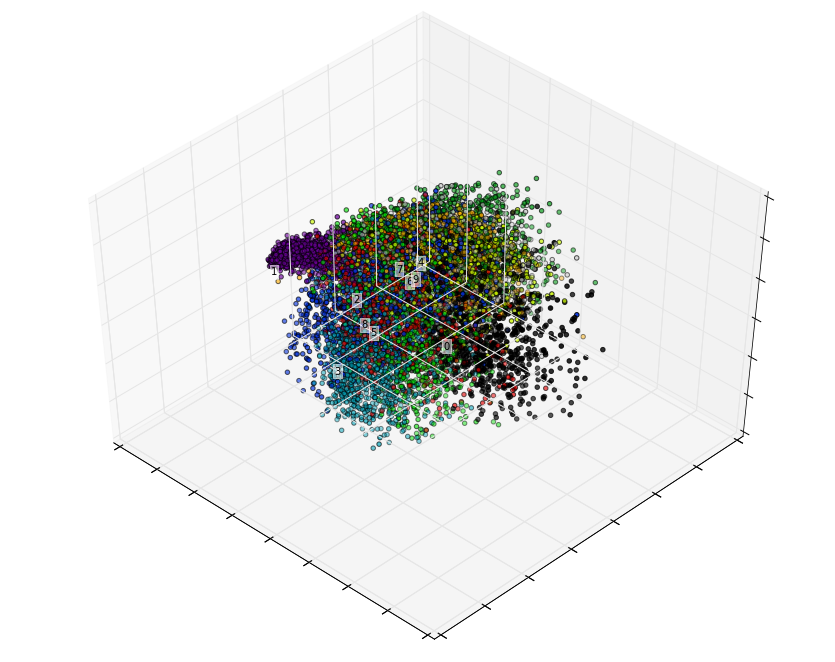

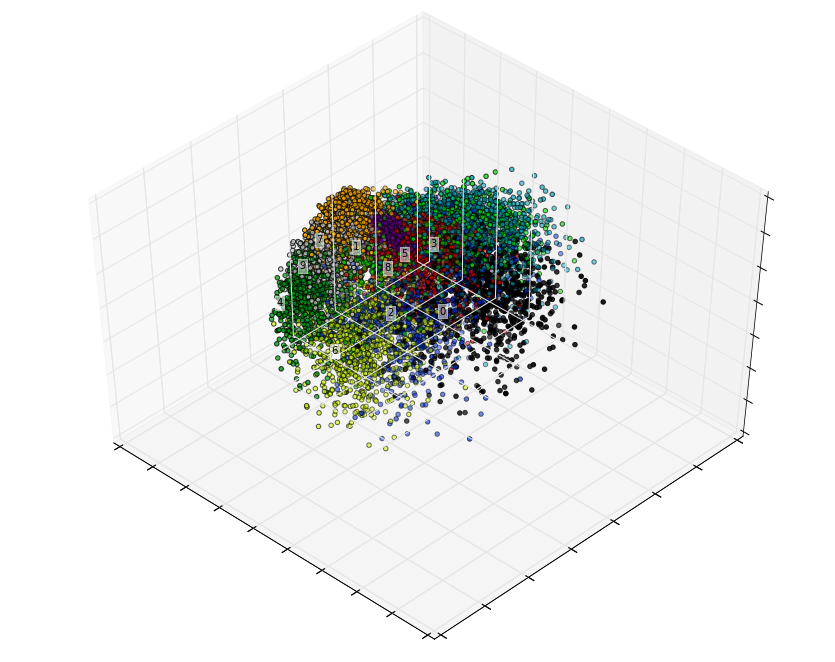

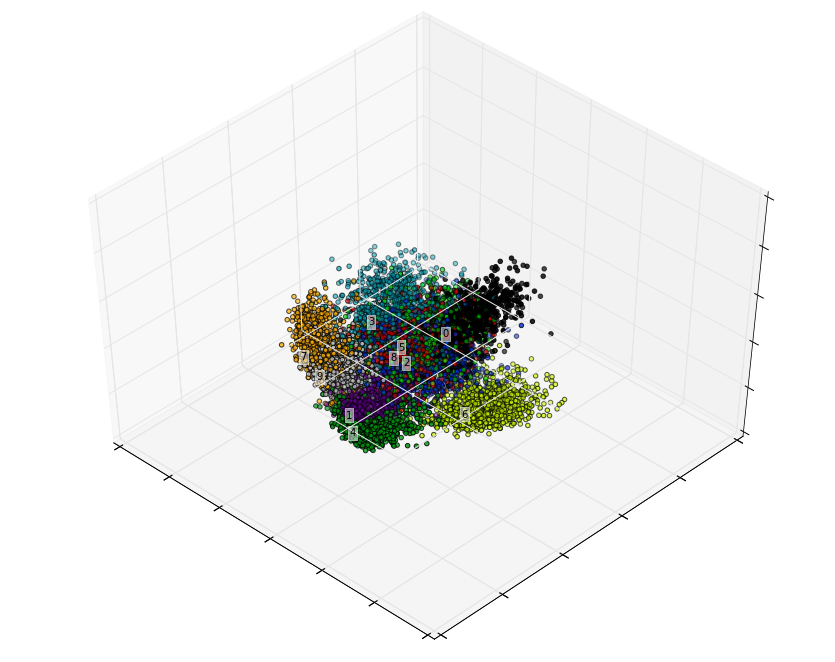

In [7]:
%matplotlib inline
#import PySide
import os,sys,time
import gzip, cPickle

import numpy, scipy, matplotlib
import pylab as pl

import theano
import theano.tensor as T

from logistic_sgd import LogisticRegression, load_data

from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from IPython.display import display
from IPython.html.widgets import interact

def ReLU(X):
    return T.maximum(X, 0.)

# start-snippet-1
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None, activation=ReLU):
        self.input = input

        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]


# start-snippet-2
class MLP(object):
    def __init__(self, rng, input, n_in, hidden_layer_sizes, n_out):
        self.hiddenLayers = []
        self.hiddenLayers.append( HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=hidden_layer_sizes[0],
            activation=ReLU
            )
        )

        for idx, size in enumerate(hidden_layer_sizes):
            self.hiddenLayers.append( HiddenLayer(
                    rng=rng,
                    input=self.hiddenLayers[idx].output,
                    n_in=hidden_layer_sizes[idx],
                    n_out=hidden_layer_sizes[idx+1],
                    activation=ReLU
                )
            )
            if idx+1 == len(hidden_layer_sizes)-1:
                break


        # The logistic regression layer gets as input the hidden units
        # of the hidden layer
        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayers[-1].output,
            n_in=hidden_layer_sizes[-1],
            n_out=n_out
        )
        # end-snippet-2 start-snippet-3
        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = (
            sum([abs(x.W).sum() for x in self.hiddenLayers])
            + abs(self.logRegressionLayer.W).sum()
        )

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = (
            sum([(x.W **2).sum() for x in self.hiddenLayers])
            + (self.logRegressionLayer.W ** 2).sum()
        )

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        #self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        self.params = self.logRegressionLayer.params
        for layer in self.hiddenLayers:
            self.params += layer.params
        # end-snippet-3


def test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=1000,
             dataset='mnist.pkl.gz', batch_size=20, hidden_layer_sizes=[100,100], seed=1234, model='../model/2layerReLUmodel-100-100'):
    model = model + '-seed-' + str(seed) + '.dat'
    datasets = load_data(dataset)

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(seed)

    # construct the MLP class
    classifier = MLP(
        rng=rng,
        input=x,
        n_in=28 * 28,
        hidden_layer_sizes=hidden_layer_sizes,
        n_out=10
    )

    with open(model, 'r') as f:
        for i, param in enumerate(classifier.params):
            classifier.params[i].set_value(cPickle.load(f), borrow=True)
    
    hid1 = ReLU(T.dot(test_set_x, classifier.params[2]) + classifier.params[3])
    hid2 = ReLU(T.dot(hid1, classifier.params[4]) + classifier.params[5])
    out10 = T.nnet.softmax(T.dot(hid2, classifier.params[0]) + classifier.params[1])
    pred = T.argmax(out10, axis=1)

    #X = test_set_x.get_value()
    #y = test_set_y.eval()

    y = test_set_y.eval()
    
    for X in [test_set_x.get_value(), hid1.eval(), hid2.eval()]:
        fig = pl.figure(1, figsize=(12,9))
        pl.clf()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
        pl.cla()
        pca = decomposition.PCA(n_components=3)
        pca.fit(X)
        X = pca.transform(X)
        centers = [[1, 1], [-1, -1], [1, -1]]

        for number in range(10):
            ax.text3D(X[y == number, 0].mean(),
                      X[y == number, 1].mean() + 1.5,
                      X[y == number, 2].mean(), str(number),
                      horizontalalignment='center',
                      bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),
                     )
        # Reorder the labels to have colors matching the cluster results
        #y = np.choose(y, [1, 2, 0]).astype(np.float)
        #ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=pl.cm.spectral)
        p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=pl.cm.spectral)
        #pl.colorbar(p)

        x_surf = [X[:, 0].min(), X[:, 0].max(), X[:, 0].min(), X[:, 0].max()]
        y_surf = [X[:, 0].max(), X[:, 0].max(), X[:, 0].min(), X[:, 0].min()]
        x_surf = numpy.array(x_surf)
        y_surf = numpy.array(y_surf)
        v0 = pca.transform(pca.components_[0])
        v0 /= v0[-1]
        v1 = pca.transform(pca.components_[1])
        v1 /= v1[-1]

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        
        pl.show()

    '''
    @interact(elev=(-90, 90), azim=(0, 360))
    def view(elev, azim):
        ax.view_init(elev, azim)
        display(ax.figure)
    '''
        
if __name__ == '__main__':
    test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=2000, dataset='mnist.pkl.gz', batch_size=20, hidden_layer_sizes=[500,500], seed=20, model='../model/2layer-ReLUmodel-500-500')    

... loading data


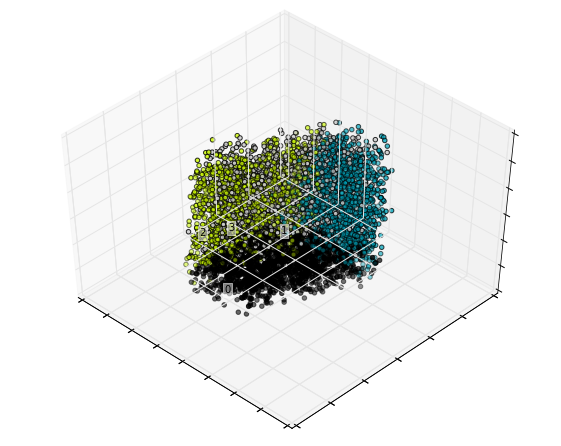

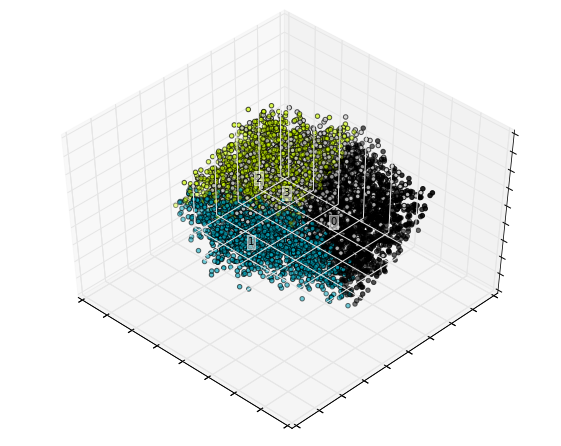

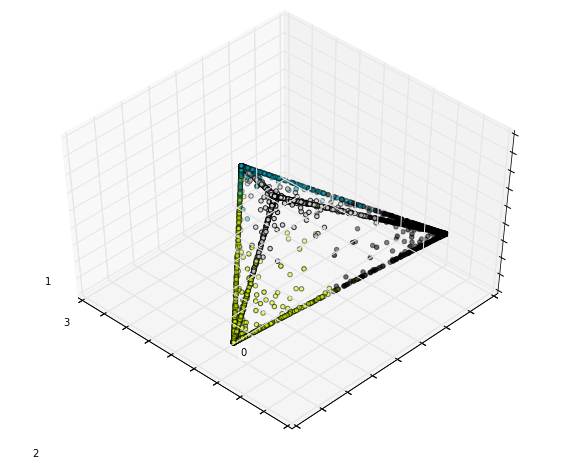

In [26]:
__docformat__ = 'restructedtext en'

import os,sys,time
import numpy, scipy, cPickle

import theano
import theano.tensor as T

from logistic_sgd import LogisticRegression

def load_data(dataset):
    print '... loading data'

    with open(dataset, 'r') as f:
        train_set = cPickle.load(f)
        valid_set = cPickle.load(f)
        test_set = cPickle.load(f)

    def shared_dataset(data_xy, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        data_x, data_y = data_xy
        shared_x = theano.shared(numpy.asarray(data_x, dtype=theano.config.floatX), borrow=borrow)
        shared_y = theano.shared(numpy.asarray(data_y, dtype=theano.config.floatX), borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets ous get around this issue
        return shared_x, T.cast(shared_y, 'int32')

    test_set_x, test_set_y = shared_dataset(test_set)
    valid_set_x, valid_set_y = shared_dataset(valid_set)
    train_set_x, train_set_y = shared_dataset(train_set)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]
    return rval

# start-snippet-1
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        self.input = input
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]


# start-snippet-2
class MLP(object):
    def __init__(self, rng, input, n_in, n_hidden, n_out):
        self.hiddenLayer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=T.tanh
        )

        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out
        )

        self.L1 = (
            abs(self.hiddenLayer.W).sum()
            + abs(self.logRegressionLayer.W).sum()
        )

        self.L2_sqr = (
            (self.hiddenLayer.W ** 2).sum()
            + (self.logRegressionLayer.W ** 2).sum()
        )

        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )

        self.errors = self.logRegressionLayer.errors

        self.params = self.hiddenLayer.params + self.logRegressionLayer.params

def test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=1000, dataset='mnist.pkl.gz', batch_size=20, n_hidden=500, seed=1234):
    datasets = load_data('../data/' + dataset)

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # standardization
    mean = train_set_x.get_value().mean(axis=0)
    std = train_set_x.get_value().std(axis=0)
    std[std == 0.0] = 1.0

    train_set_x.set_value(train_set_x.get_value() - mean)
    train_set_x.set_value(train_set_x.get_value() / std)
    valid_set_x.set_value(valid_set_x.get_value() - mean)
    valid_set_x.set_value(valid_set_x.get_value() / std)
    test_set_x.set_value(test_set_x.get_value() - mean)
    test_set_x.set_value(test_set_x.get_value() / std)

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(seed)

    # construct the MLP class
    classifier = MLP(
        rng=rng,
        input=x,
        n_in=4,
        n_hidden=n_hidden,
        n_out=4
    )

    model_name = '../model/dim4-s-1000.dat'
    with open(model_name, 'r') as f:
        for i, param in enumerate(classifier.params):
            classifier.params[i].set_value(cPickle.load(f), borrow=True)
    
    hid1 = ReLU(T.dot(test_set_x, classifier.params[0]) + classifier.params[1])
    out4 = T.nnet.softmax(T.dot(hid1, classifier.params[2]) + classifier.params[3])
    pred = T.argmax(out4, axis=1)

    y = test_set_y.eval()
    
    for X in [test_set_x.get_value(), hid1.eval(), out4.eval()]:
        fig = pl.figure(1, figsize=(8,6))
        pl.clf()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
        pl.cla()
        pca = decomposition.PCA(n_components=3)
        pca.fit(X)
        X = pca.transform(X)
        centers = [[1, 1], [-1, -1], [1, -1]]

        for number in range(10):
            ax.text3D(X[y == number, 0].mean(),
                      X[y == number, 1].mean() + 1.5,
                      X[y == number, 2].mean(), str(number),
                      horizontalalignment='center',
                      bbox=dict(alpha=.5, edgecolor='w', facecolor='w'),
                     )
        # Reorder the labels to have colors matching the cluster results
        #y = np.choose(y, [1, 2, 0]).astype(np.float)
        #ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=pl.cm.spectral)
        p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=pl.cm.spectral)
        #pl.colorbar(p)

        x_surf = [X[:, 0].min(), X[:, 0].max(), X[:, 0].min(), X[:, 0].max()]
        y_surf = [X[:, 0].max(), X[:, 0].max(), X[:, 0].min(), X[:, 0].min()]
        x_surf = numpy.array(x_surf)
        y_surf = numpy.array(y_surf)
        v0 = pca.transform(pca.components_[0])
        v0 /= v0[-1]
        v1 = pca.transform(pca.components_[1])
        v1 /= v1[-1]

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        
        pl.show()

if __name__ == '__main__':
    test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=1000, dataset='dim4-interval(0,100)_length-50000_seed-35.dat', batch_size=20, n_hidden=500, seed=1)
